In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    init_lifecycle,
)

from HARK.Calibration.Income.IncomeTools import (
    parse_income_spec,
    parse_time_params,
    CGM_income,
)

from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy
from HARK.utilities import plot_funcs

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
Agent = IndShockConsumerType(**params)
Agent.solve()

Consumption functions


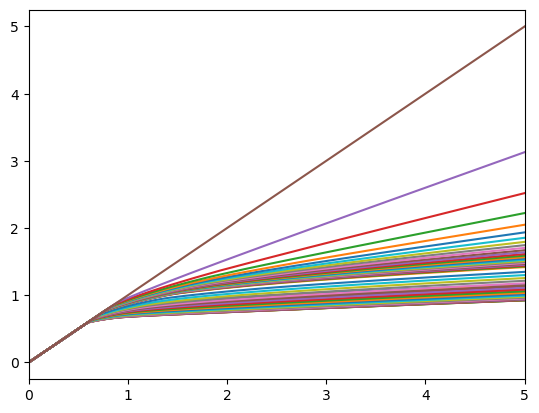

In [4]:
Agent.unpack("cFunc")
# Plot the consumption functions
print("Consumption functions")
plot_funcs(Agent.cFunc, 0, 5)

In [5]:
# Number of agents and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[  0.28209054,   0.95160955,   0.34891832, ...,   1.7643852 ,
           2.84032528,   0.23631086],
        [  0.22529731,   0.9272609 ,   0.61835261, ...,   1.69427636,
           1.81036404,   0.13468547],
        [  0.58441403,   1.83244217,   0.58516438, ...,   1.36486706,
           2.54674396,   0.93770108],
        ...,
        [  3.97000739, 107.08342369,   3.43790459, ...,   4.41859522,
           9.15867051,  13.95871722],
        [  4.6699412 ,  99.71430057,   4.38909421, ...,   3.28417047,
           9.88006378,  17.98913132],
        [  7.03643122,  92.35488736,   5.09911528, ...,   3.13732662,
           8.21567243,  15.58233352]]),
 'cNrm': array([[ 0.84072933,  0.95525117,  0.86100528, ...,  1.02398219,
          1.09949365,  0.824016  ],
        [ 0.8110178 ,  0.93834029,  0.90189049, ...,  1.00129188,
          1.00968381,  0.769138  ],
        [ 0.88933675,  0.99849916,  0.88944183, ...,  0.96497575,
          1.04601324,  0.9296288 ],
        ...,
  

In [6]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

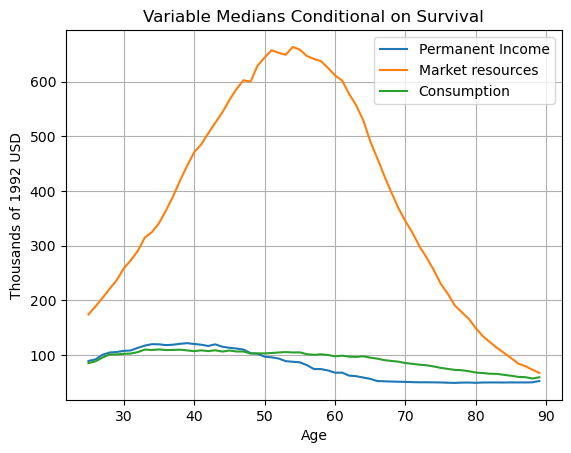

In [7]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()